# Trained the model with variable selection and with the dataset that already has a dimentional reduction variables

## Setup and load the data

### Import libraries and declare functions

In [1]:
import os
import sys
# Only for final delivery
import warnings
warnings.filterwarnings('ignore')
# libraries for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="white")
# Libraries models
import pandas as pd
import numpy as np
from collections import Counter
from time import time
# Set some Pandas options
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
import seaborn as sns
# Library's to apply balance technic's
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the necessary module's
from scipy.stats import chi2
from sklearn.preprocessing import MinMaxScaler,binarize
from sklearn.feature_selection import SelectKBest,mutual_info_classif,chi2,RFE,RFECV,SelectFromModel
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate,cross_val_score
from sklearn.svm import LinearSVC,SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,average_precision_score
from sklearn.metrics import roc_curve,classification_report,confusion_matrix,make_scorer
from xgboost import XGBRegressor,XGBClassifier
# library to save the models
import joblib

In [2]:
def get_na(df):
    qsna=df.shape[0]-df.isnull().sum(axis=0)
    qna=df.isnull().sum(axis=0)
    ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %',ascending=False)

def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

def variable_selection(X,y):
    
    # Generamos la métrica de mutual information de los features con respecto al Score 
    mi = mutual_info_classif(X,y,random_state=0,discrete_features='auto')
    # Creamos el dataframe con los resultados
    raw_data={'features':X.columns.values,'m-score':mi,'m-weight':mi/np.max(mi)}
    features_mi=pd.DataFrame(raw_data,columns=['features','m-score','m-weight'])
    features_mi=features_mi.sort_values(by='m-weight',ascending=False)
    
    # Generamos el el clasificador con Random Forest
    clf = RandomForestClassifier(
        bootstrap=True, criterion='gini',max_features='sqrt',min_samples_split=23,
        n_estimators=300,random_state=0,warm_start=True,n_jobs=-1, min_samples_leaf =23)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Random Forest
    rfe_rf = RFE(clf, n_features_to_select=1)
    fit_rf = rfe_rf.fit(X, y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_rf':fit_rf.ranking_}
    features_ffe_rf=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_rf']).sort_values(by='ranking_ffe_rf',ascending=True)
    selected_features=pd.merge(left=features_mi,right=features_ffe_rf, how='left', on='features', 
                               sort=False,suffixes=('_mi', '_ffe_rf'), copy=True, indicator=False)
    
    # Generamos el el clasificador con Regresión logística
    model = LogisticRegression(random_state=0,warm_start=True)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Regresión Logística
    rfe_lr = RFE(model, n_features_to_select=1)
    fit_rl = rfe_lr.fit(X, y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_rl':fit_rl.ranking_}
    features_ffe_rl=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_rl']).sort_values(by='ranking_ffe_rl',ascending=True)
    selected_features=pd.merge(left=selected_features,right=features_ffe_rl, how='left', on='features', left_on=None, 
                               sort=False,suffixes=('', '_ffe_rl'), copy=True, 
                               indicator=False)
    
    # Generamos el el clasificador con Gradient Boosting
    model = GradientBoostingClassifier(
        random_state=0,max_features='sqrt',subsample=0.8,
        n_estimators=300,min_samples_split = 20,warm_start=True)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Gradient Boosting
    rfe_gb = RFE(model, n_features_to_select=1)
    fit_gb = rfe_gb.fit(X=X, y=y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_gb':fit_gb.ranking_}
    features_ffe_gb=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_gb']).sort_values(by='ranking_ffe_gb',ascending=True)
    selected_features=pd.merge(left=selected_features,right=features_ffe_gb, how='left', on='features',
                               suffixes=('', '_ffe_gb'), copy=True, indicator=False)
    
    # Generamos el el clasificador con Linear SVC
    lsvc = LinearSVC(C=1, penalty="l1", random_state=0,dual=False,loss='squared_hinge').fit(X, y)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Linear SVC
    model = SelectFromModel(lsvc, prefit=True)
    X_new = model.transform(X)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'coef_svc':np.abs(lsvc.coef_[0])}
    features_svc=pd.DataFrame(raw_data,columns=['features','coef_svc']).sort_values(by='coef_svc',ascending=False)
    features_svc['ranking_svc']=range(1,len(lsvc.coef_[0])+1)
    selected_features=pd.merge(left=selected_features,right=features_svc, how='left', on='features',
                               sort=False,suffixes=('', '_svc_lineal'), copy=True, indicator=False)
    
    return selected_features

### Loading pre-processed dataset and split the data

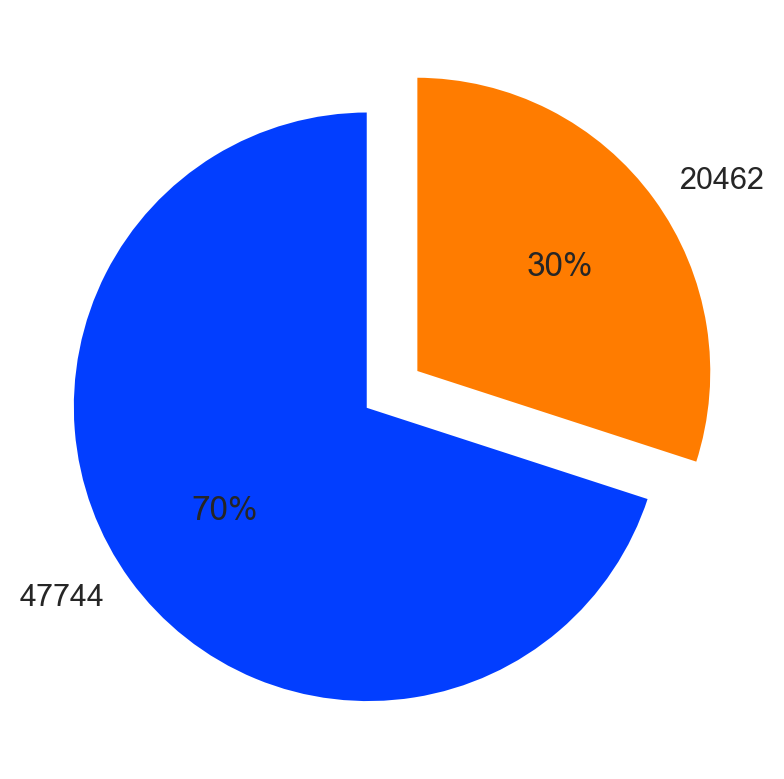

In [3]:
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
os.chdir(directory_path)
path = os.getcwd() + '/data/interim/model_data_mca.csv' 
mca = pd.read_csv(path, sep=',')
path = os.getcwd() + '/data/interim/model_data.csv' 
df = pd.read_csv(path, sep=',')
y = df.atraso_15
del df
#get_na(mca)
# Split the data
X_train, X_test, y_train, y_test = train_test_split(mca, y, test_size=0.3, random_state=100)
#define data
data = [X_train.shape[0],X_test.shape[0] ]
labels = [data[0], data[1]]
#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:2]
#create pie chart
plt.pie(data, labels = labels, colors = colors,startangle=90, 
        autopct='%1.f%%',explode=(0.1,0.1))
plt.show()

### Train the models in the dataset with 20 components

#### Train the five models and compare results

In [4]:
clf = DecisionTreeClassifier(random_state=0, max_features='sqrt',criterion='gini',
                             min_samples_split=0.01)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
print(scores.mean())
clf.fit(X_train, y_train)
y_pred_probs = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
report = classification_report(y_test, y_pred)
print(report)
cm

0.35974186841468814
              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89     16660
         1.0       0.33      0.04      0.07      3802

    accuracy                           0.81     20462
   macro avg       0.57      0.51      0.48     20462
weighted avg       0.73      0.81      0.74     20462



Predicted class,0.0,1.0,All
Actual class,,,
0.0,16352,308,16660
1.0,3651,151,3802
All,20003,459,20462


In [5]:
clf = LogisticRegression()
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
print(scores.mean())
clf.fit(X_train, y_train)
y_pred_probs = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
report = classification_report(y_test, y_pred)
print(report)
cm

0.175
              precision    recall  f1-score   support

         0.0       0.81      1.00      0.90     16660
         1.0       0.25      0.00      0.00      3802

    accuracy                           0.81     20462
   macro avg       0.53      0.50      0.45     20462
weighted avg       0.71      0.81      0.73     20462



Predicted class,0.0,1.0,All
Actual class,,,
0.0,16648,12,16660
1.0,3798,4,3802
All,20446,16,20462


In [6]:
clf = RandomForestClassifier(n_estimators=500,random_state=0,warm_start=True,criterion='gini',
                             bootstrap=True,max_features='sqrt',class_weight = 'balanced')
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
print(scores.mean())
clf = RandomForestClassifier(n_estimators=500,random_state=0,warm_start=True,criterion='gini',
                             bootstrap=True,max_features='sqrt',class_weight = 'balanced')
clf.fit(X_train, y_train)
clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
report = classification_report(y_test, y_pred)
print(report)
cm

0.3255840440436708
              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86     16660
         1.0       0.32      0.22      0.26      3802

    accuracy                           0.77     20462
   macro avg       0.58      0.56      0.56     20462
weighted avg       0.74      0.77      0.75     20462



Predicted class,0.0,1.0,All
Actual class,,,
0.0,14949,1711,16660
1.0,2980,822,3802
All,17929,2533,20462


In [7]:
clf = XGBClassifier(random_state=0, ,verbosity = 0)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
print(scores.mean())
clf.fit(X_train, y_train)
y_pred_probs = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
report = classification_report(y_test, y_pred)
print(report)
cm

[14:05:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:05:05] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:22:37] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:576: 
Parameters: { "verbose

Predicted class,0.0,1.0,All
Actual class,,,
0.0,16222,438,16660
1.0,3420,382,3802
All,19642,820,20462
